In [2]:
import os
import numpy as np
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.efficientnet import EfficientNetB0

In [3]:
# create a data generator
datagen = ImageDataGenerator(validation_split=0.1)
# Image size determined by EfficientNetB0
IMG_SIZE = 224

# load and iterate training dataset
train_it = datagen.flow_from_directory(
    '../master-data/train_small/rgb', 
    target_size=(IMG_SIZE, IMG_SIZE),
    subset="training", 
    class_mode="sparse",
    batch_size=32)

val_it = datagen.flow_from_directory(
    '../master-data/train_small/rgb', 
    target_size=(IMG_SIZE, IMG_SIZE), 
    subset="validation", 
    class_mode="sparse",
    batch_size=32)

Found 27011 images belonging to 11 classes.
Found 3000 images belonging to 11 classes.


In [4]:
# Create a MirroredStrategy.
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

optimizer = Adam(learning_rate=0.0001)

#early stopping to monitor the validation loss and avoid overfitting
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)

#reducing learning rate on plateau
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor= 0.5, min_lr= 1e-6, verbose=1)

# Open a strategy scope.
with strategy.scope():
    input_shape = (IMG_SIZE, IMG_SIZE, 3)
    n_classes = 11
    efnb0 = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape, classes=n_classes)

    model = Sequential()
    model.add(efnb0)
    model.add(GlobalAveragePooling2D())
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(n_classes, activation='softmax'))
    model.summary()
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model on all available devices.
history = model.fit(train_it, epochs=30, verbose=1, validation_data=val_it, callbacks=[early_stop, rlrop], workers=10)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2022-01-11 21:00:44.647591: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-01-11 21:00:44.650080: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-01-11 21:00:44.734333: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:1a:00.0 name: Tesla V100-SXM2-16GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 15.78GiB deviceMemoryBandwidth: 836.37GiB/s
2022-01-11 21:00:44.735278: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:1c:00.0 name: Tesla V100-SXM2-16GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 15.78GiB deviceMemoryBandwidth: 836.37GiB/s
2022-01-11 21:00:44.735308: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-

Number of devices: 2
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).

2022-01-11 21:00:53.069662: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:656] In AUTO-mode, and switching to DATA-based sharding, instead of FILE-based sharding as we cannot find appropriate reader dataset op(s) to shard. Error: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_13413"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_FLOAT
      type: DT_FLOAT
    }
  }
}
. Consider eit

Epoch 1/30
INFO:tensorflow:batch_all_reduce: 215 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 215 all-reduces with algorithm = nccl, num_packs = 1


2022-01-11 21:01:24.613154: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-01-11 21:01:26.393172: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2022-01-11 21:01:28.580163: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2022-01-11 21:01:28.679188: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


845/845 [==============================] - ETA: 0s - loss: 1.8738 - accuracy: 0.4159

2022-01-11 21:09:30.548921: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:656] In AUTO-mode, and switching to DATA-based sharding, instead of FILE-based sharding as we cannot find appropriate reader dataset op(s) to shard. Error: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_63028"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_FLOAT
      type: DT_FLOAT
    }
  }
}
. Consider eit

845/845 [==============================] - 613s 479ms/step - loss: 1.8731 - accuracy: 0.4161 - val_loss: 1.2700 - val_accuracy: 0.6660
Epoch 2/30
845/845 [==============================] - 148s 173ms/step - loss: 0.6270 - accuracy: 0.7857 - val_loss: 0.8225 - val_accuracy: 0.7530
Epoch 3/30
845/845 [==============================] - 146s 172ms/step - loss: 0.4239 - accuracy: 0.8559 - val_loss: 0.7782 - val_accuracy: 0.7793
Epoch 4/30
845/845 [==============================] - 142s 167ms/step - loss: 0.3103 - accuracy: 0.8944 - val_loss: 1.1933 - val_accuracy: 0.7253
Epoch 5/30
845/845 [==============================] - 148s 174ms/step - loss: 0.2505 - accuracy: 0.9131 - val_loss: 0.6627 - val_accuracy: 0.8123
Epoch 6/30
845/845 [==============================] - 144s 168ms/step - loss: 0.1969 - accuracy: 0.9329 - val_loss: 0.5910 - val_accuracy: 0.8350
Epoch 7/30
845/845 [==============================] - 145s 170ms/step - loss: 0.1590 - accuracy: 0.9438 - val_loss: 1.9714 - val_accura

In [10]:
model.save_weights("efficientnetb0_weights.h5")
model.save('./efficientnet', save_format='tf')

2022-01-11 22:27:25.643374: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./efficientnet/assets


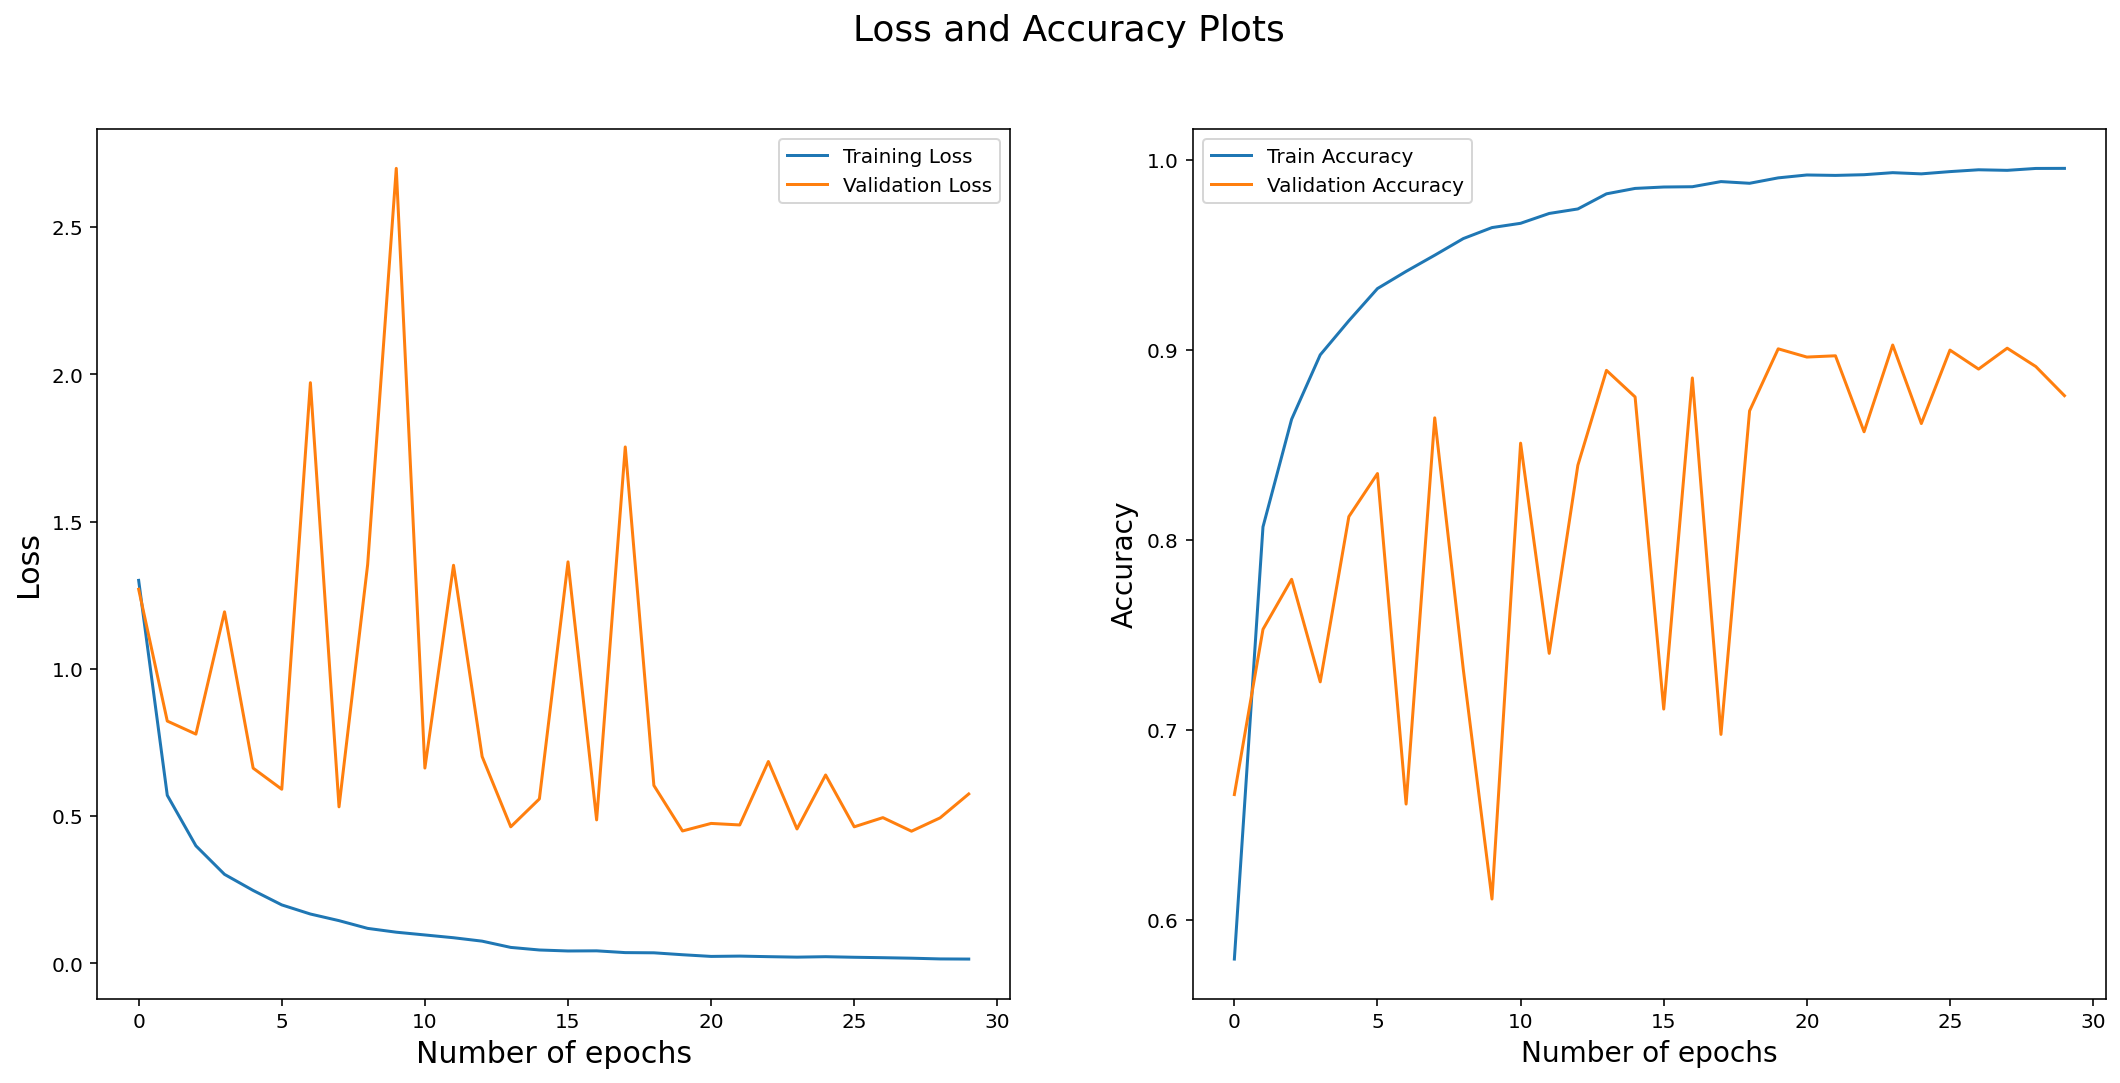

In [11]:
#plot to visualize the loss and accuracy against number of epochs
plt.figure(figsize=(18,8))

plt.suptitle('Loss and Accuracy Plots', fontsize=18)

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Number of epochs', fontsize=15)
plt.ylabel('Loss', fontsize=15)

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel('Number of epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.show()

In [17]:
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    # loading the saved model
    loaded_model = tf.keras.models.load_model('./efficientnet')
    # retraining the model
    loaded_model.fit(train_it, epochs=10, verbose=1, validation_data=val_it, workers=10)

2022-01-11 22:42:32.167599: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:656] In AUTO-mode, and switching to DATA-based sharding, instead of FILE-based sharding as we cannot find appropriate reader dataset op(s) to shard. Error: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_526078"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_FLOAT
      type: DT_FLOAT
    }
  }
}
. Consider ei

Epoch 1/10
845/845 [==============================] - ETA: 0s - loss: 0.0154 - accuracy: 0.9952

2022-01-11 22:45:11.222018: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:656] In AUTO-mode, and switching to DATA-based sharding, instead of FILE-based sharding as we cannot find appropriate reader dataset op(s) to shard. Error: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_575703"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_FLOAT
      type: DT_FLOAT
    }
  }
}
. Consider ei

845/845 [==============================] - 178s 170ms/step - loss: 0.0154 - accuracy: 0.9952 - val_loss: 0.4720 - val_accuracy: 0.8990
Epoch 2/10
845/845 [==============================] - 139s 163ms/step - loss: 0.0165 - accuracy: 0.9950 - val_loss: 0.4773 - val_accuracy: 0.8973
Epoch 3/10
845/845 [==============================] - 136s 159ms/step - loss: 0.0165 - accuracy: 0.9949 - val_loss: 0.4770 - val_accuracy: 0.9023


2022-01-11 22:50:04.944428: W tensorflow/core/framework/op_kernel.cc:1751] Invalid argument: TypeError: 'NoneType' object is not subscriptable
Traceback (most recent call last):

  File "/home/users/tdejesus/miniconda3/envs/efinet/lib/python3.7/site-packages/tensorflow/python/ops/script_ops.py", line 249, in __call__
    ret = func(*args)

  File "/home/users/tdejesus/miniconda3/envs/efinet/lib/python3.7/site-packages/tensorflow/python/autograph/impl/api.py", line 620, in wrapper
    return func(*args, **kwargs)

  File "/home/users/tdejesus/miniconda3/envs/efinet/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py", line 891, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/home/users/tdejesus/miniconda3/envs/efinet/lib/python3.7/site-packages/tensorflow/python/keras/engine/data_adapter.py", line 807, in wrapped_generator
    for data in generator_fn():

  File "/home/users/tdejesus/miniconda3/envs/efinet/lib/python3.7/site-

Epoch 4/10
845/845 [==============================] - 140s 164ms/step - loss: 0.0139 - accuracy: 0.9955 - val_loss: 0.4818 - val_accuracy: 0.8997
Epoch 5/10
845/845 [==============================] - 143s 168ms/step - loss: 0.0137 - accuracy: 0.9957 - val_loss: 0.6368 - val_accuracy: 0.8623
Epoch 6/10
845/845 [==============================] - 142s 167ms/step - loss: 0.0140 - accuracy: 0.9957 - val_loss: 0.4962 - val_accuracy: 0.8947
Epoch 7/10
845/845 [==============================] - 143s 168ms/step - loss: 0.0126 - accuracy: 0.9960 - val_loss: 0.4476 - val_accuracy: 0.9080
Epoch 8/10
845/845 [==============================] - 140s 165ms/step - loss: 0.0118 - accuracy: 0.9964 - val_loss: 0.4567 - val_accuracy: 0.9050
Epoch 9/10
845/845 [==============================] - 144s 169ms/step - loss: 0.0154 - accuracy: 0.9947 - val_loss: 0.5001 - val_accuracy: 0.8960
Epoch 10/10
845/845 [==============================] - 139s 163ms/step - loss: 0.0127 - accuracy: 0.9964 - val_loss: 0.5586 

In [18]:
model.save_weights("efficientnetb0_weights-1.h5")
model.save('./efficientnet-1', save_format='tf')

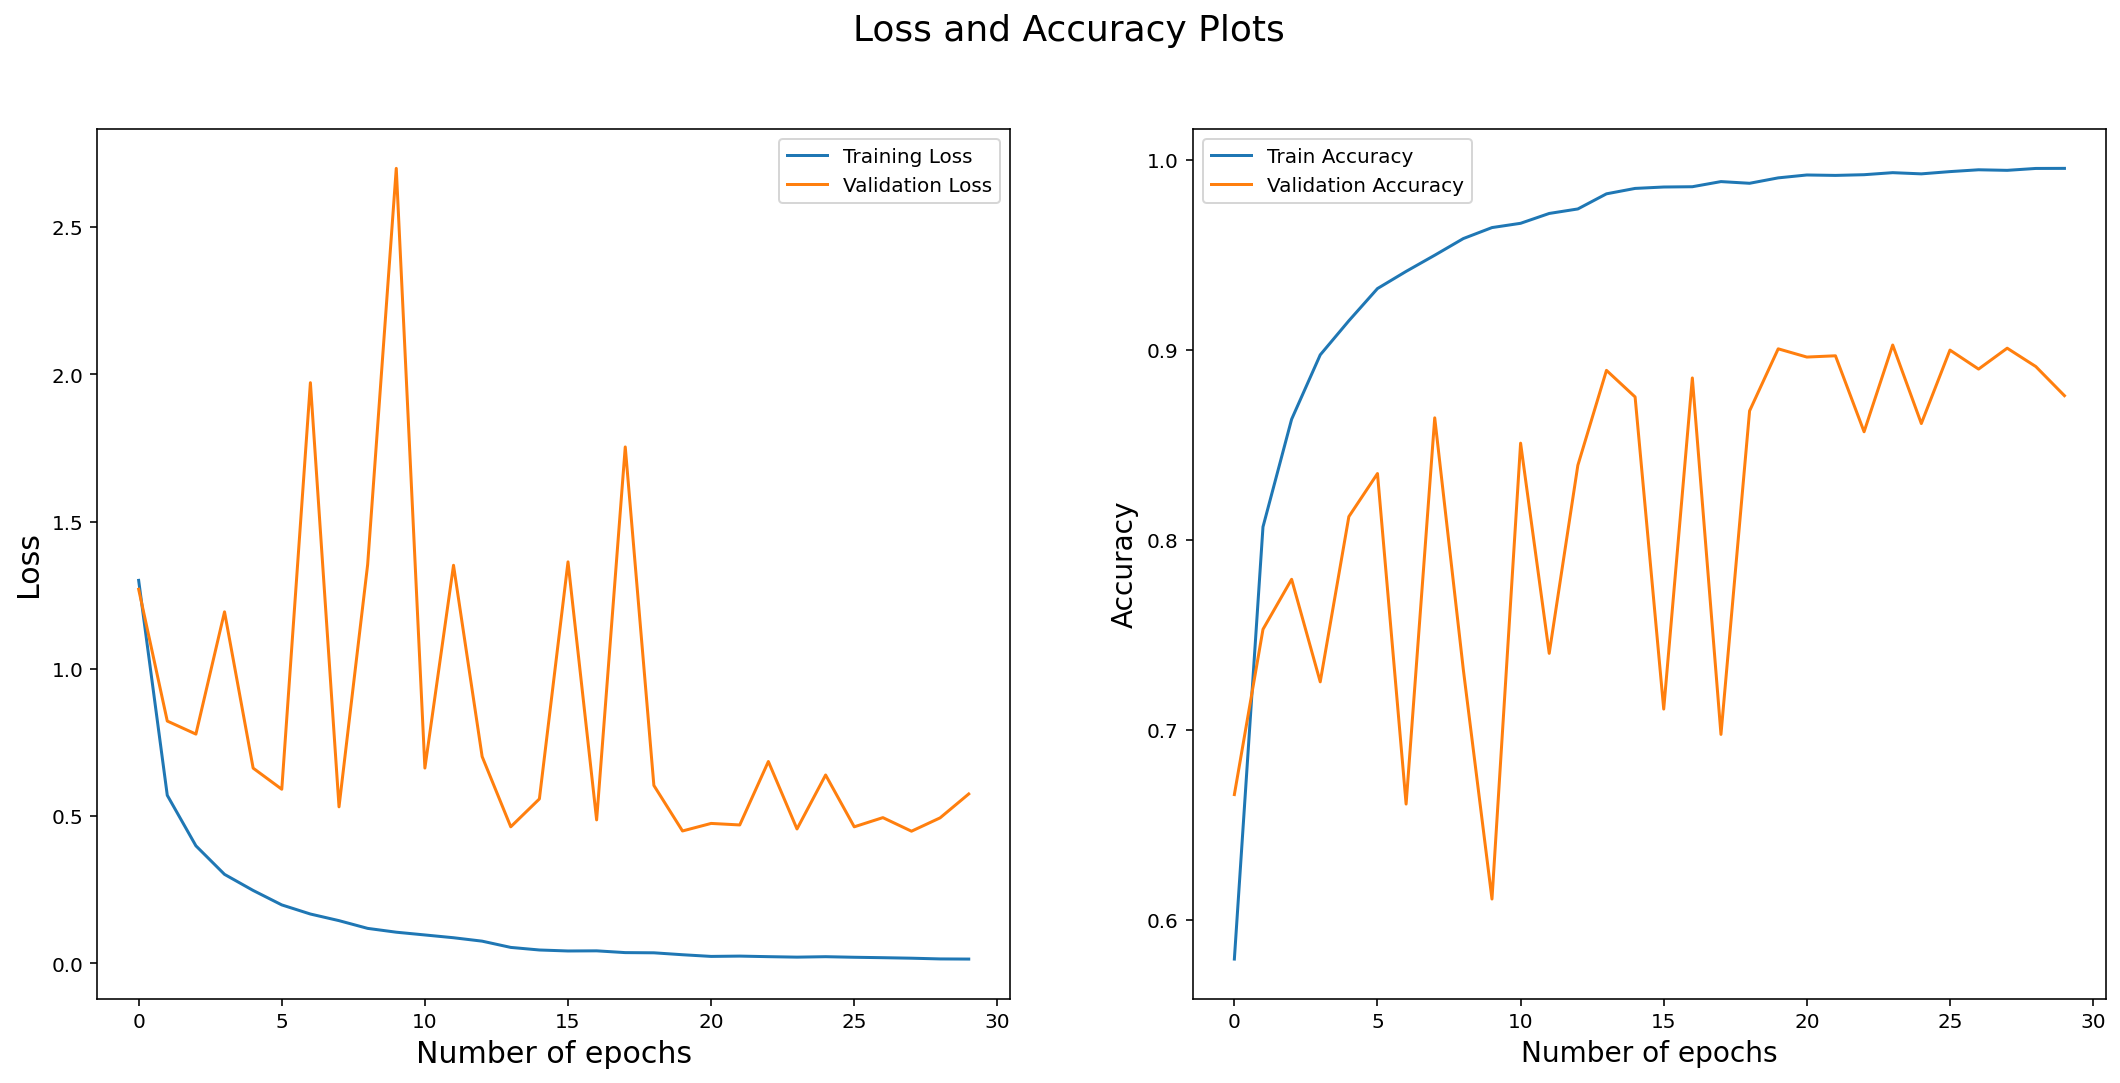

In [19]:
#plot to visualize the loss and accuracy against number of epochs
plt.figure(figsize=(18,8))

plt.suptitle('Loss and Accuracy Plots', fontsize=18)

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Number of epochs', fontsize=15)
plt.ylabel('Loss', fontsize=15)

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel('Number of epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.show()